#### Dans ce Notebook nous allons simuler des prédictions puis nous allons calculer et afficher les performances de nos modèles 

Il faut utiliser l'environnement de train comme Kernel 

In [134]:
import pandas as pd 
import numpy as np 

import requests
import json

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import *
from pandas.tseries.offsets import MonthEnd

On commence par récuperer nos données 

Le dataset comprend également des donnees pour les mois suivant. 

Nous les utiliserons pour simuler des predictions et calculer les potentielles performances de notre modele servi par l'API 

In [135]:
# import Data 

data = pd.read_csv('../data/flat_data.csv') 
# on convertit en datetime notre colonne de date 

data["date"] = pd.to_datetime(data["date"]) 
data 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,coef_ajustement
0,5561000190,2014-05-02,4.375000e+05,3,2.25,1970,35100,2.0,0,0,...,1970,0,1977,0,98027,47.4635,-121.991,2340,35100,1.000000
1,472000620,2014-05-02,7.900000e+05,3,2.50,2600,4750,1.0,0,0,...,1700,900,1951,0,98117,47.6833,-122.400,2380,4750,1.000000
2,1024069009,2014-05-02,6.750000e+05,5,2.50,2820,67518,2.0,0,0,...,2820,0,1979,0,98029,47.5794,-122.025,2820,48351,1.000000
3,7853361370,2014-05-02,5.550000e+05,4,2.50,3310,6500,2.0,0,0,...,3310,0,2012,0,98065,47.5150,-121.870,2380,5000,1.000000
4,5056500260,2014-05-02,4.400000e+05,4,2.25,2160,8119,1.0,0,0,...,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1422700040,2015-05-14,2.102280e+05,3,1.00,1170,7320,1.0,0,0,...,1170,0,1962,0,98188,47.4685,-122.282,2040,7320,1.148787
21609,8730000270,2015-05-14,4.124146e+05,2,2.75,1370,1140,2.0,0,0,...,1080,290,2009,0,98133,47.7052,-122.343,1370,1090,1.148787
21610,7923600250,2015-05-15,5.171361e+05,5,2.00,1870,7344,1.5,0,0,...,1870,0,1960,0,98007,47.5951,-122.144,1870,7650,1.149191
21611,5101400871,2015-05-24,5.121449e+05,2,1.75,1390,6670,1.0,0,0,...,720,670,1941,0,98115,47.6914,-122.308,920,6380,1.149596


In [136]:
# fonction qui nous renvoit un x (12features) et un Y(price) à partir du dataset ajusté sur un interval entre deux dates
def extract_interval(start_date,end_date):
    try:
        # on filtre sur notre interval de date
        mask = (data['date'] >= start_date) & (data['date'] <= end_date)
        data_prep = data.loc[mask]
    
    except Exception as ex:
        print(ex)
        raise print("mauvais format de dates, attendu AAAA-MM-JJ")
    x= data_prep[['view','lat','waterfront','bedrooms','bathrooms','sqft_basement','sqft_above','sqft_living','sqft_living15','floors','grade','yr_built']]

    Y = data_prep['price']
    return x,Y

In [137]:
# fonction pour évaluer nos prédictions

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [236]:
# on va tester notre modèle sur chaque mois à partir du start_date 
# pour assurer la stabilité des résultats nous lissons les performances sur 2 mois glissants

def display_res(start_date,end_date): 
  r2_tab=[] 
  rmse_tab=[] 
  date_tab=[] 
  start_date = pd.to_datetime(start_date)+relativedelta(months=1)
  start_date = start_date.strftime("%Y-%m-%d")
  for beg in pd.date_range(start_date, end_date, freq='MS'): 
      # on lisse notre résultat sur 2 mois glissants 
      start = pd.to_datetime(beg)-relativedelta(months=1) 
      end = beg + MonthEnd(0) 
      (x,Y) = extract_interval(start,end) 
      print(start.strftime("%Y-%m-%d"),"-->",end.strftime("%Y-%m-%d"),'nbr_pred',len(Y)) 
      batchRecords = x.to_json(orient="records")
      predicted_prices = predictPriceBatch(batchRecords)
      (rmse,mae,r2) = eval_metrics(Y,predicted_prices) 
      r2_tab.append(r2) 
      rmse_tab.append(rmse) 
      date_tab.append(beg.strftime("%Y-%m-%d")) 
      print("  RMSE: %s" % rmse) 
      print("  MAE: %s" % mae) 
      print("  R2: %s" % r2) 
      print()    
   
  # affichage graphique 
  fig, ax = plt.subplots(figsize = (10, 5)) 
  # titre du graphique  
  plt.title('evolution des metrics en fonction du temps')   
   
  # using the twinx() for creating another 
  # axes object for secondry y-Axis 
  ax2 = ax.twinx() 
  ax.plot(date_tab, r2_tab, color = 'g',label="R2") 
  ax2.plot(date_tab, rmse_tab, color = 'b',label="RSME") 
  ax.set_xlabel('Date') 
  ax2.set_ylabel('RSME', color = "b") 
  ax.set_ylabel('R2', color = 'g') 

  ax.axhline(y=0.78,color='gray',linestyle='--')
  ax2.set_ylim(100000,250000)
  ax.set_ylim(0.7,0.85)
  # defining display layout 
  fig.legend() 
  plt.show()

In [237]:
# créons notre fonction de prédiction
# cette fonction va faire un appel unitaire à l'API avec une requete POST

# exemple payload
# payload = {
#    "view" : 0,
#    "lat": 47.4639,
#    "waterfront": 0,
#    "bedrooms": 3,
#    "bathrooms": 2.5,
#    "sqft_basement": 0,
#    "sqft_above": 3970,
#    "sqft_living": 3970,
#    "sqft_living15": 5340,
#    "floors":7,
#    "grade":7,
#    "yr_built": 1973
# }

def predictPriceStream(payload):
    # payload est un JSON 
    url = "http://localhost:8000/stream"

    headers = {
    'Content-Type': 'text/plain'
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    return response.text

def predictPriceBatch(payloads):
    # payload est un JSON 
    url = "http://localhost:8000/batch"

    headers = {
    'Content-Type': 'text/plain'
    }
    response = requests.request("POST", url, headers=headers, data=payloads)
    return json.loads(response.text)

2014-11-01 --> 2014-12-31 nbr_pred 2882
  RMSE: 155249.56131640502
  MAE: 87738.46007821361
  R2: 0.8371110306450008

2014-12-01 --> 2015-01-31 nbr_pred 2449
  RMSE: 157651.4328564787
  MAE: 91620.1738673993
  R2: 0.83864972620349

2015-01-01 --> 2015-02-28 nbr_pred 2228
  RMSE: 179889.1949652018
  MAE: 99166.95796817337
  R2: 0.7771399656248058

2015-02-01 --> 2015-03-31 nbr_pred 3125
  RMSE: 186956.93128670295
  MAE: 109138.94474077778
  R2: 0.7651715090597623

2015-03-01 --> 2015-04-30 nbr_pred 4106
  RMSE: 203105.76372384845
  MAE: 121033.81770880813
  R2: 0.7560497879661537

2015-04-01 --> 2015-05-31 nbr_pred 2877
  RMSE: 226736.9514014082
  MAE: 131130.0629031944
  R2: 0.7262366096787829



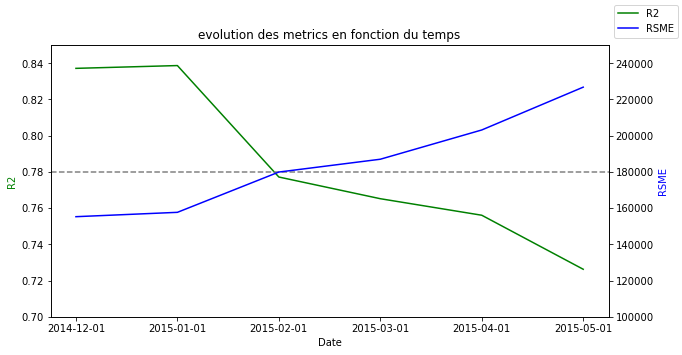

In [238]:
# on fait notre première observation avec un modèle entrainé avec des données de Mai à Décembre 2015
# on observe une diminution des performances à partir du mois de Février (drift des données liée à une augmentation des prix en fonction du temps)
display_res("2014-11-01","2015-05-01")

2015-02-01 --> 2015-03-31 nbr_pred 3125
  RMSE: 178278.43484569195
  MAE: 104847.36006721051
  R2: 0.7864668677321631

2015-03-01 --> 2015-04-30 nbr_pred 4106
  RMSE: 194283.44019099537
  MAE: 116001.16146950482
  R2: 0.7767824824710515

2015-04-01 --> 2015-05-31 nbr_pred 2877
  RMSE: 216211.68931908853
  MAE: 125107.66092695462
  R2: 0.7510631987894918



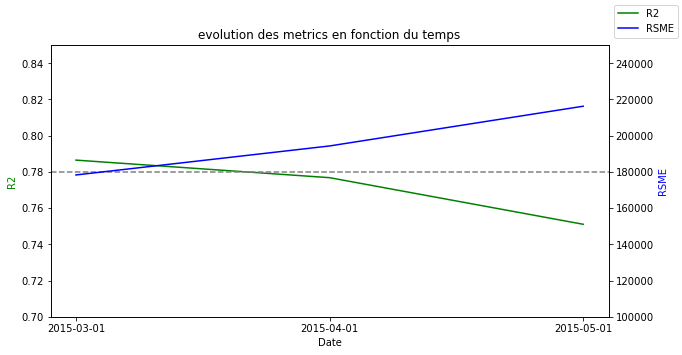

In [240]:
# nous avons réentrainé un modèle avec des données plus récentes allant jusqu'a Février 2015.
# nous voyons que le nouveau modèle est beaucoup plus précis sur les mois de Mars à Mai 2015
display_res("2015-02-01","2015-05-01")
# Nous observons alors qu'un réentrainement est encore à prévoir au mois suivant
# Cependant, les performances au mois de Mai seront toujours plus exactes que celles du modèle précédent